## Imports

In [35]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.linalg import expm
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import random
from qiskit.quantum_info import Operator
import pandas as pd

# Network Graph & Adjacency matrix



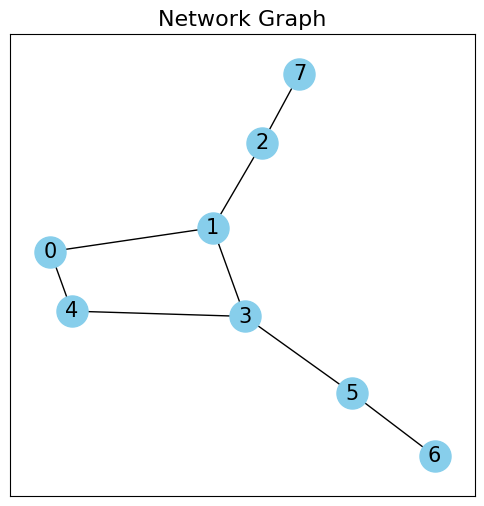

In [36]:
# Step 1: Define the network graph
G = nx.Graph()
edges = [(0, 1), (1, 2), (1,3), (0,4), (4,3), (3,5), (5,6), (2,7) ]  # Sequential connections
G.add_edges_from(edges)

# Step 2: Plot the graph
plt.figure(figsize=(6, 6))
nx.draw_networkx(G, with_labels=True, node_color='skyblue', node_size=500, font_size=15)
plt.title("Network Graph", fontsize=16)
plt.show()

In [37]:
# Step 3: Adjacency matrix of the graph
adj_matrix = nx.adjacency_matrix(G).toarray()
print("Adjacency Matrix:")
print(adj_matrix)

# Define the Hermitian matrix A for use in the quantum link prediction
A = adj_matrix.astype(float)

Adjacency Matrix:
[[0 1 0 0 1 0 0 0]
 [1 0 1 1 0 0 0 0]
 [0 1 0 0 0 0 0 1]
 [0 1 0 0 1 1 0 0]
 [1 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 1 0]
 [0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0]]


# Quantum Random Walk


In [19]:

def quantum_walk_t(A,t,n:int): 
    """
    Creates a quantum circuit for a quantum random walk at a specific time t starting at node n

    """
    # Intialize a quantum circuit
    num_target_qubits = int(np.log2(A.shape[0]))  # Infer target qubits from A
    qc = QuantumCircuit(num_target_qubits)  

    # Convert n to binary
    binary= format(n, f'0{num_target_qubits}b')
    
    # Encode starting node 
    for i, bit in enumerate(reversed(binary)):  # Reverse to match Qiskit's qubit indexing
        if bit == '1':
            qc.x(i)

    # Calculate e^{-iAt}
    i = complex(0, 1)
    U_minus = expm(-i * A * t)  # e^{-iAt}



    qc.unitary(Operator(U_minus), range(num_target_qubits))

    qc.measure_all()

    return qc

def measure_quantum_circuit(qc, simulator: str):
    """
        Runs a simulation of a quantum circuit and returns counts at that point
    """ 
    sim = Aer.get_backend(simulator) 
    result = sim.run(qc).result()
    counts = result.get_counts()
    return counts

def add_max_and_avg(df):
    """
    Adds a row with the maximum value of each column (P-max) and the average of each column (P-avg).
    """
    # Find max values
    p_max = df.drop('Time', axis=1).max()
    
    # Find average values
    p_avg = df.drop('Time', axis=1).mean()

    # Add to DF 
    df.loc[len(df)] = ['P-max'] + p_max.tolist()
    df.loc[len(df)] = ['P-avg'] + p_avg.tolist()
    
    return df

100


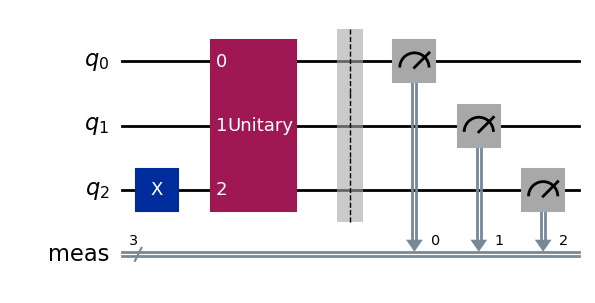

In [16]:
qc = quantum_walk_t(A,0,4)

qc.draw("mpl")

{'100': 1024}


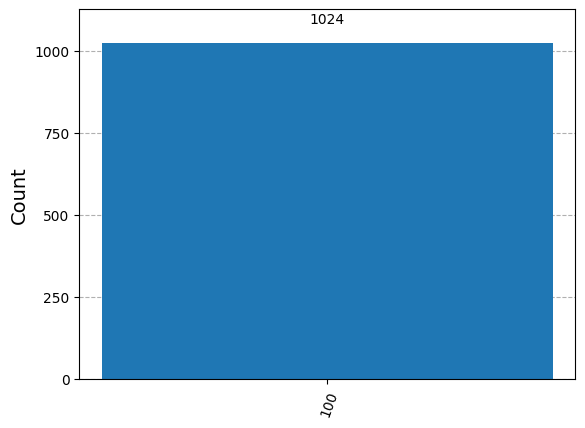

In [17]:
counts= measure_quantum_circuit(qc,'aer_simulator')
print (counts)
plot_histogram(counts)

In [40]:

def calculate_possible_nodes(A):
    """
    Calculate the possible nodes based on the number of qubits.
    """
    num_target_qubits = int(np.log2(A.shape[0])) 

    # Generate all possible binary combinations
    possible_nodes = [format(i, f'0{num_target_qubits}b') for i in range(2**num_target_qubits)]
    
    return possible_nodes

def create_results_df(possible_nodes): 
    columns = ['Time'] + possible_nodes
    results_df = pd.DataFrame(columns=columns)
    return results_df


In [33]:
possible_nodes = ['000', '001', '010', '011', '100', '101', '110', '111']

columns = ['Time'] + possible_nodes
results_df = pd.DataFrame(columns=columns)

# Possible nodes


for i in np.arange(0, 20, 0.5): 
    qc = quantum_walk_t(A,i,7)
    counts= measure_quantum_circuit(qc,'aer_simulator')
    possible_nodes= ['000', '001', '010', '011', '100','101','110','111']
    for node in possible_nodes: 
        if node not in counts:
            counts[node] = 0
    shots = 1024
    probabilities = {key: value / shots for key, value in counts.items()}
    # saving to dataframe
    row = [i] + [probabilities[node] for node in possible_nodes]
    results_df.loc[len(results_df)] = row

print(results_df)

    Time       000       001       010       011       100       101  \
0    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1    0.5  0.000977  0.009766  0.219727  0.000977  0.000000  0.000000   
2    1.0  0.016602  0.110352  0.525391  0.013672  0.004883  0.000977   
3    1.5  0.074219  0.287109  0.455078  0.066406  0.056641  0.008789   
4    2.0  0.122070  0.271484  0.205078  0.055664  0.291992  0.034180   
5    2.5  0.071289  0.183594  0.014648  0.000977  0.604492  0.028320   
6    3.0  0.000977  0.151367  0.042969  0.058594  0.622070  0.000000   
7    3.5  0.012695  0.168945  0.177734  0.098633  0.410156  0.078125   
8    4.0  0.041016  0.126953  0.374023  0.040039  0.170898  0.196289   
9    4.5  0.037109  0.051758  0.278320  0.000000  0.067383  0.212891   
10   5.0  0.065430  0.004883  0.085938  0.026367  0.047852  0.071289   
11   5.5  0.097656  0.010742  0.005859  0.029297  0.017578  0.000000   
12   6.0  0.076172  0.077148  0.150391  0.008789  0.001953  0.10

In [34]:

add_max_and_avg(results_df)

print(results_df.tail(2))

     Time       000       001       010       011       100       101  \
40  P-max  0.218750  0.419922  0.525391  0.098633  0.622070  0.611328   
41  P-avg  0.064453  0.135962  0.123120  0.028833  0.161401  0.139624   

         110       111  
40  0.375977  1.000000  
41  0.106104  0.240503  
